# Audible metadata

In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import seaborn as sns
import numpy as np
import datetime as dt
from bs4 import BeautifulSoup
import requests


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)

#add data path
path='../data/'

/Users/saijananiganesan/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Useful functions

In [2]:
def fetch_and_clean_data(path=path,fname='Audible_metadata.csv'):
    df=pd.read_csv(path+fname)
    cleaned=df.drop('Unnamed: 0',1)
    cleaned=cleaned[cleaned['Category']!='Category']
    cleaned= cleaned.astype(str)
    cleaned['Release Date'] = pd.to_datetime(cleaned['Release Date'],errors='coerce')
    cleaned['Runtime']=cleaned.Runtime.apply(convert_runtime)
    cleaned['Ratings']=cleaned.Ratings.apply(convert_ratings)
    cleaned['Reviewers']=cleaned.Reviewers.apply(convert_reviewers)
    return cleaned

def convert_runtime(length):
    if 'min' in length and 'hr' in length:
        hrs = int(length.split(' hr')[0].replace(' ',''))
        mins = int(length.split('min')[0].split('and ')[1].replace(' ',''))
        total = hrs + mins/60
    elif 'min' in length:
        total = int(length.split('min')[0].replace(' ',''))/60
    elif 'hr' in length:
        total = int(length.split('hr')[0].replace(' ',''))
    else:
        total = 0
    return total

def convert_ratings(rate):
    if 'None' in rate:
        rate_=0
    else:
        rate_=int(rate)
    return rate_

def convert_reviewers(rev):
    if 'None' in rev:
        rev_=0
    elif ',' in rev:
        rev_=int(rev.replace(',',''))
    else:
        rev_=int(rev)
    return rev_

def mute_colors(axis):
    for patch in axis.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))


In [25]:
df=fetch_and_clean_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163453 entries, 0 to 163474
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Category        163453 non-null  object        
 1   Sub Category    163453 non-null  object        
 2   Book Name       163453 non-null  object        
 3   Book Link       163453 non-null  object        
 4   Subtitle        163453 non-null  object        
 5   Author Names    163453 non-null  object        
 6   Narrator Names  163453 non-null  object        
 7   Runtime         163453 non-null  float64       
 8   Release Date    163453 non-null  datetime64[ns]
 9   Ratings         163453 non-null  int64         
 10  Reviewers       163453 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 15.0+ MB


### A quick overview of the dataset. 
#### The current database has ~80% of Audible's database of >200,000 books. The books are all in english and are strictly audiobooks (excludes interviews, radio performances, interviews or lectures)

In [103]:
Total=df.groupby(['Category']).count()['Sub Category'].sum()
Total_books=len(df['Book Name'].unique())
print ("Total number of books in the current dataset is:%d"%Total_books)
print ("Total number of hours of books in the current dataset is:%f million"%round(df['Runtime'].sum()/1e6,2))

Total number of books in the current dataset is:92311
Total number of hours of books in the current dataset is:1.240000 million


### Exploratory data analysis

#### Analyzing of the composition in terms of books and number of hours

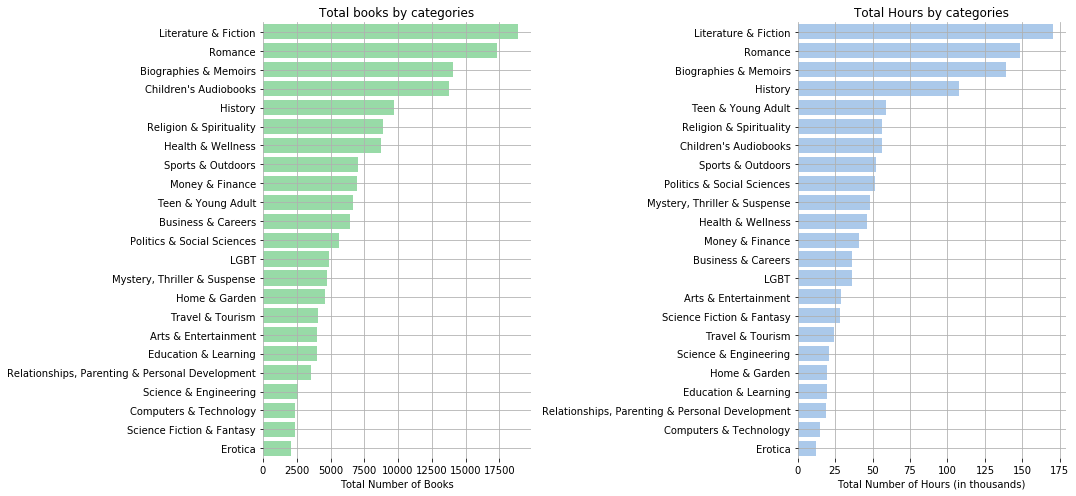

In [5]:
categories=df.groupby(['Category']).count().sort_values(by=['Sub Category'],ascending=False).reset_index()
Runtime=df.groupby(['Category']).sum().sort_values(by=['Runtime'],ascending=False)['Runtime'].apply(lambda x:x/1000).reset_index()
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 7));
sns.set_color_codes("pastel");
sns.barplot(x="Sub Category", y="Category", data=categories, color="g",ax=ax1);
ax1.set(ylabel="",xlabel="Total Number of Books",title='Total books by categories');
sns.barplot(x="Runtime", y="Category", data=Runtime,color="b",ax=ax2);
ax2.set(ylabel="",xlabel="Total Number of Hours (in thousands)",title='Total Hours by categories');
ax2.grid(True);ax1.grid(True);
plt.tight_layout();
sns.despine(left=True, bottom=True);


#### Fiction, romance, and biographies are the top three categories. The number of books in the dataset is strongly correlated with the number of hours, especially in the top three categories.

### Which categories have the most reviews?

In [6]:
df.groupby(['Category'])['Reviewers'].mean().sort_values(ascending=False)

Category
Science Fiction & Fantasy                          2355.690213
Mystery, Thriller & Suspense                       1042.556882
Literature & Fiction                                832.571391
Teen & Young Adult                                  583.538069
Business & Careers                                  523.806406
Politics & Social Sciences                          495.852581
Biographies & Memoirs                               479.447053
Science & Engineering                               385.986106
Romance                                             371.306158
History                                             354.189981
Children's Audiobooks                               321.303334
Money & Finance                                     260.238736
Arts & Entertainment                                214.349195
Erotica                                             211.358398
Relationships, Parenting & Personal Development     207.953877
Religion & Spirituality                       

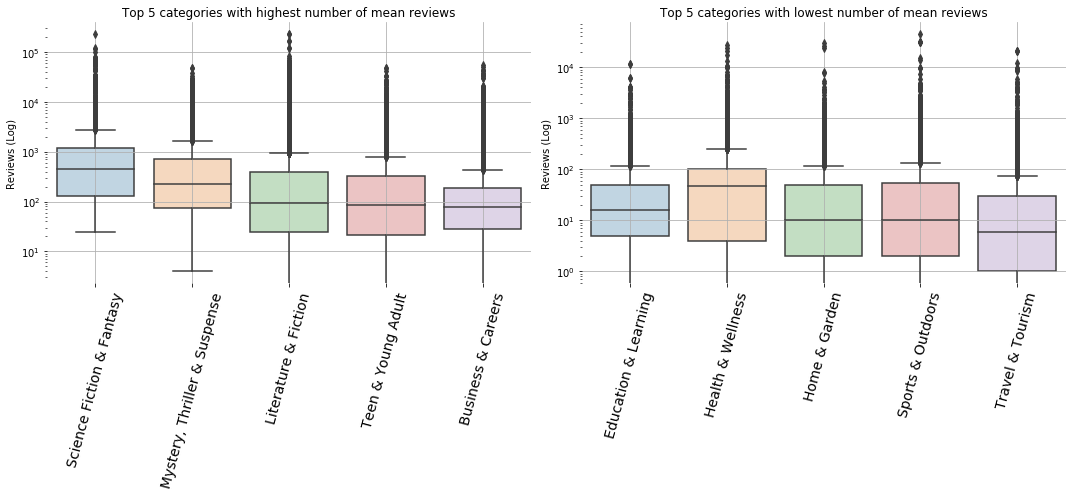

In [7]:
Review_l=df.groupby(['Category'])['Reviewers'].mean().nlargest(5).index
Review_s=df.groupby(['Category'])['Reviewers'].mean().nsmallest(5).index
sns.set_color_codes("muted");

f, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 7));
revplot = sns.boxplot(x='Category', y='Reviewers', 
                    data=df[(df['Category'].isin(Review_l))],ax=ax1,order=Review_l);
ax1.set(ylabel="Reviews (Log)",xlabel='',title='Top 5 categories with highest number of mean reviews')
ax1.set_xticklabels(revplot.get_xticklabels(), rotation=75, fontsize=14)
ax1.set(yscale="log")
mute_colors(ax1)

revplot2 = sns.boxplot(x='Category', y='Reviewers', 
                    data=df[(df['Category'].isin(Review_s))],ax=ax2);
ax2.set(ylabel="Reviews (Log)",xlabel='',title='Top 5 categories with lowest number of mean reviews')
ax2.set_xticklabels(revplot2.get_xticklabels(), rotation=75, fontsize=14)
ax2.set(yscale="log")
mute_colors(ax2)

ax1.grid(True);ax2.grid(True);
plt.tight_layout();
sns.despine(left=True, bottom=True);

#### Science fiction & fantasy is the category with the most number of (mean) reviews (2355.7) and education & learning is the category with the least number of (mean) reviews (80.78). This is an intuitive result as it is difficult to learn from audiobooks. This also points to a discrepancy between a large amount of audiobooks and a smaller amount of reviews, hence a recommendation should rely less on reviews.

### Are there any recent trends in the database?

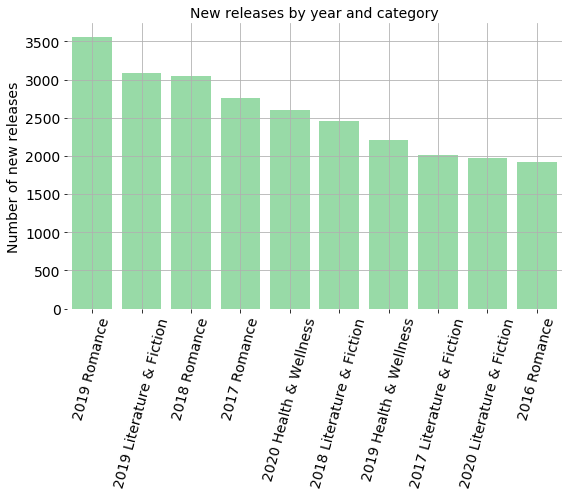

In [8]:
t=df.groupby([df['Release Date'].dt.year,'Category']).count().sort_values(by='Sub Category',ascending=False).iloc[0:10,:]
t['tuple_yr_cat']=t.index
f, ax = plt.subplots(figsize=(8, 7));
sns.set_color_codes("pastel");
yr=sns.barplot(x="tuple_yr_cat", y="Sub Category", data=t, color="g",ax=ax);
ax.set(xlabel="");
ax.set_xticklabels(yr.get_xticklabels(), rotation=75, fontsize=14)
ax.tick_params(labelsize=14)
labels = [str(item.get_text()).replace(',','').replace('(','').replace(')','').replace("'","") for item in ax.get_xticklabels()]
ax.set_xticklabels(labels,fontsize=14)
ax.set_title('New releases by year and category',fontsize=14)
ax.set_ylabel(ylabel="Number of new releases",fontsize=14)

ax.grid(True);
plt.tight_layout();
sns.despine(left=True, bottom=True);


#### Most of the new books added to the database are in the two popular categories (fiction and romance). It is also interesting to note that the heath and wellness category is in the top 10 list; this could be due to the interest in health and wellness in recent years, or more specifically, the pandemic

### What's the proportion of ratings in each category?

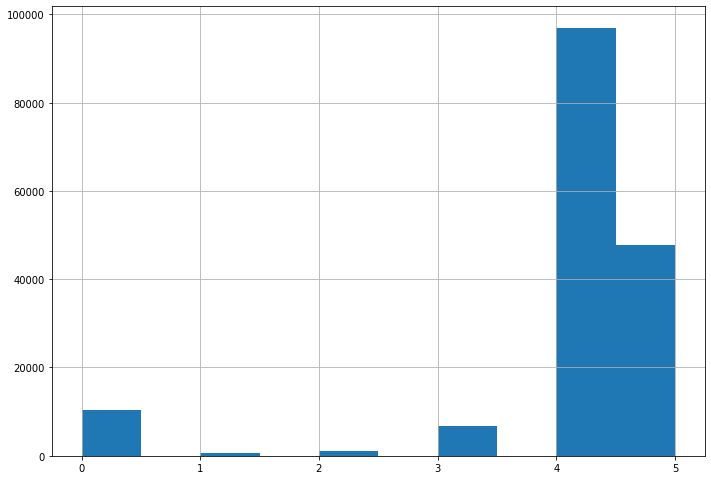

In [30]:
df.Ratings.hist()

In [105]:
#df['Binary_Ratings']=df['Ratings'].apply(lambda x: 1 if x>0 else 0)
Cat=df.groupby(['Category','Ratings']).count().reset_index()
Cat
Cat['Sub Category'].sum()

Category  Ratings  Sub Category  Book Name  Book Link  \
0    Arts & Entertainment        0           349        349        349   
1    Arts & Entertainment        1            13         13         13   
2    Arts & Entertainment        2            17         17         17   
3    Arts & Entertainment        3           252        252        252   
4    Arts & Entertainment        4          2639       2639       2639   
..                    ...      ...           ...        ...        ...   
121      Travel & Tourism        1            75         75         75   
122      Travel & Tourism        2           121        121        121   
123      Travel & Tourism        3           522        522        522   
124      Travel & Tourism        4          2030       2030       2030   
125      Travel & Tourism        5           519        519        519   

     Subtitle  Author Names  Narrator Names  Runtime  Release Date  Reviewers  \
0         349           349             349      349           349        349   
1          13            13              13       13            13         13   
2          17            17              17       17            17         17   
3         252           252             252      252           252        252   
4        2639          2639            2639     2639          2639       2639   
..        ...           ...             ...      ...           ...        ...   
121        75            75              75       75            75         75   
122       121           121             121      121           121        121   
123       522           522             522      522           522        522   
124      2030          2030            2030     2030          2030       2030   
125       519           519             519      519           519        519   

     Binary_Ratings  
0               349  
1                13  
2                17  
3               252  
4              2639  
..              ...  
121              75  
122             121  
123             522  
124            2030  
125             519  

[126 rows x 12 columns]

163453

In [407]:
ct = pd.crosstab(df['Category'], df['Ratings']).reset_index().sort_values(by=4,ascending=False)
ct['Total']=ct[0]+ct[1]+ct[2]+ct[3]+ct[4]+ct[5]
ct.sort_values(by='Total',ascending=False,inplace=True)
ct.head()
del ct['Total']
ct=ct.iloc[::-1]
ct=ct.tail(10)

Ratings               Category     0   1   2    3      4     5  Total
11        Literature & Fiction   610  22  52  616  12439  5157  18896
17                     Romance   242  12  27  319  13111  3584  17295
1        Biographies & Memoirs   362  15  26  256  10840  2600  14099
3        Children's Audiobooks  2629  76  77  402   6518  4065  13767
8                      History   475  19  45  533   7027  1623   9722

[Text(0, 0.5, ''),
 Text(0.5, 0, 'Total Number of Books (Audible)'),
 Text(0.5, 1.0, ' ')]

[Text(0, 0, 'Teen & Young Adult'),
 Text(0, 0, 'Money & Finance'),
 Text(0, 0, 'Sports & Outdoors'),
 Text(0, 0, 'Health & Wellness'),
 Text(0, 0, 'Religion & Spirituality'),
 Text(0, 0, 'History'),
 Text(0, 0, "Children's Audiobooks"),
 Text(0, 0, 'Biographies & Memoirs'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Literature & Fiction')]

Text(0.5, 0, 'Total Number of Books (Audible)')

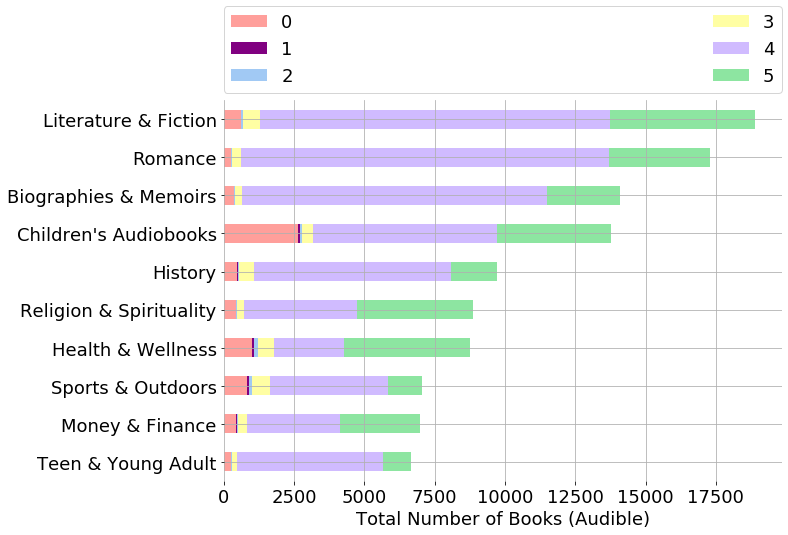

In [413]:
f, ax1 = plt.subplots(1,1,figsize=(10, 7));
f=ct.plot.barh(stacked=True,ax=ax1,color=['r','purple','b','y','m','g'])
ax1.set(xlabel="Total Number of Books (Audible)",ylabel='',title=' ',);
ax1.set_yticklabels(ct['Category'], fontsize=14);
mute_colors(ax1);
ax1.grid(True);
mute_colors(ax1)
ax1.set_xlabel(xlabel="Total Number of Books (Audible)",fontsize=18)
#plt.tight_layout();
sns.despine(left=True, bottom=True);
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.,fontsize=18)

ax1.tick_params(axis='both', which='major', labelsize=18)


## Which narrator-categories and author-categories are most populat?

In [303]:
NN_cat=df.groupby(['Narrator Names']).count().sort_values(by='Reviewers',ascending=False).iloc[0:20,:].reset_index()
NN_cat

Narrator Names  Category  Sub Category  Book Name  Book Link  \
0                 None       797           797        797        797   
1            Intuitive       517           517        517        517   
2          Simon Vance       447           447        447        447   
3        Sean Runnette       387           387        387        387   
4       Grover Gardner       376           376        376        376   
5          Dave Wright       346           346        346        346   
6           Sean Pratt       343           343        343        343   
7        Derek Perkins       334           334        334        334   
8         Kevin Pierce       320           320        320        320   
9          Joe Barrett       319           319        319        319   
10        Paul Boehmer       315           315        315        315   
11       Tavia Gilbert       313           313        313        313   
12      Michael Pauley       308           308        308        308   
13         Scott Brick       305           305        305        305   
14     MacLeod Andrews       303           303        303        303   
15            John Lee       299           299        299        299   
16  Cassandra Campbell       299           299        299        299   
17       Jason Belvill       284           284        284        284   
18      Trevor Clinger       281           281        281        281   
19      Hollie Jackson       275           275        275        275   

    Subtitle  Author Names  Runtime  Release Date  Ratings  Reviewers  \
0        797           797      797           797      797        797   
1        517           517      517           517      517        517   
2        447           447      447           447      447        447   
3        387           387      387           387      387        387   
4        376           376      376           376      376        376   
5        346           346      346           346      346        346   
6        343           343      343           343      343        343   
7        334           334      334           334      334        334   
8        320           320      320           320      320        320   
9        319           319      319           319      319        319   
10       315           315      315           315      315        315   
11       313           313      313           313      313        313   
12       308           308      308           308      308        308   
13       305           305      305           305      305        305   
14       303           303      303           303      303        303   
15       299           299      299           299      299        299   
16       299           299      299           299      299        299   
17       284           284      284           284      284        284   
18       281           281      281           281      281        281   
19       275           275      275           275      275        275   

    Binary_Ratings  
0              797  
1              517  
2              447  
3              387  
4              376  
5              346  
6              343  
7              334  
8              320  
9              319  
10             315  
11             313  
12             308  
13             305  
14             303  
15             299  
16             299  
17             284  
18             281  
19             275

Narrator Names                      Category      Runtime  Ratings  \
0             Jim Dale         Children's Audiobooks   416.983333      183   
1  Tim Gerard Reynolds          Literature & Fiction   947.733333      217   
2             Jim Dale     Science Fiction & Fantasy   116.416667       35   
3            R.C. Bray     Science Fiction & Fantasy   880.233333      321   
4          Wil Wheaton          Literature & Fiction    66.300000       23   
5        Davina Porter                       Romance   698.516667       83   
6            R.C. Bray          Literature & Fiction  1044.966667      408   
7          Roy Dotrice          Literature & Fiction   233.583333       28   
8   Cassandra Campbell          Literature & Fiction   432.850000      144   
9       Susan Ericksen  Mystery, Thriller & Suspense  1275.966667      475   

   Reviewers  Binary_Ratings  
0   1.131570              42  
1   0.586738              50  
2   0.557657               7  
3   0.509375              68  
4   0.474819               5  
5   0.459978              18  
6   0.426765              89  
7   0.387430               6  
8   0.366835              36  
9   0.318886             113

[Text(0, 0.5, ''), Text(0.5, 0, 'Total Number of Books')]

Text(0.5, 24.0, 'Total Number of Reviews (Mil)')

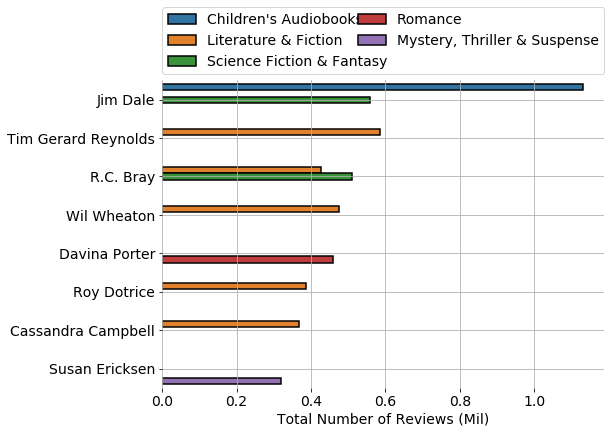

In [298]:
NN_cat=df.groupby(['Narrator Names','Category']).sum().sort_values(by='Reviewers',ascending=False).iloc[0:10,:].reset_index()
NN_cat['Reviewers']=NN_cat['Reviewers'].apply(lambda x:x/1e6)
NN_cat
f, ax1 = plt.subplots(1,1,figsize=(8, 5));
sns.set_color_codes("pastel");
sns.barplot(y="Narrator Names", x="Reviewers", data=NN_cat, hue='Category',ax=ax1,
           linewidth=1.5,
                 errcolor="0", edgecolor="0");
ax1.set(ylabel='',xlabel="Total Number of Books");
ax1.grid(True);
#ax1.set(xscale="log")

plt.tight_layout();
sns.despine(left=True, bottom=True);

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.,fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel(xlabel="Total Number of Reviews (Mil)",fontsize=14)


Author Names                      Category      Runtime  Ratings  \
0         J.K. Rowling         Children's Audiobooks   490.166667      147   
1         Stephen King          Literature & Fiction   903.783333      188   
2         J.K. Rowling     Science Fiction & Fantasy   237.166667       65   
3         Rick Riordan         Children's Audiobooks  1284.633333      492   
4       Diana Gabaldon                       Romance   687.966667       79   
5         Ernest Cline          Literature & Fiction    47.000000       14   
6  George R. R. Martin          Literature & Fiction   342.733333       60   
7    Brandon Sanderson          Literature & Fiction   318.166667       71   
8         Stephen King  Mystery, Thriller & Suspense   331.666667       69   
9        Craig Alanson     Science Fiction & Fantasy   255.666667       71   

   Reviewers  Binary_Ratings  
0   1.193434              30  
1   0.581046              44  
2   0.575950              13  
3   0.485284             116  
4   0.463364              17  
5   0.459995               3  
6   0.435197              14  
7   0.354709              16  
8   0.352450              16  
9   0.340084              15

[Text(0, 0.5, ''), Text(0.5, 0, 'Total Number of Books')]

Text(0.5, 24.0, 'Total Number of Reviews (Mil)')

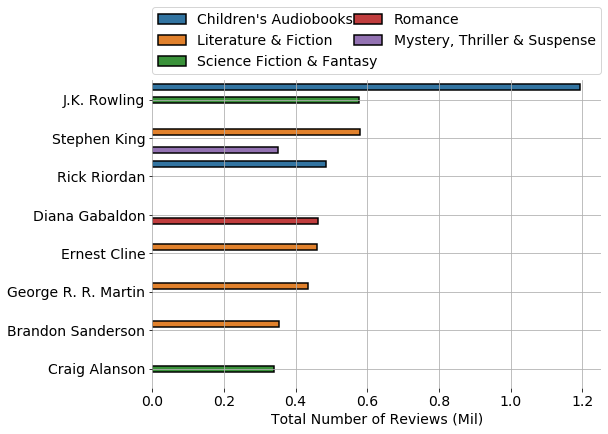

In [297]:
NN_cat=df.groupby(['Author Names','Category']).sum().sort_values(by='Reviewers',ascending=False).iloc[0:10,:].reset_index()
NN_cat['Reviewers']=NN_cat['Reviewers'].apply(lambda x:x/1e6)
NN_cat
f, ax1 = plt.subplots(1,1,figsize=(8, 5));
sns.set_color_codes("pastel");
sns.barplot(y="Author Names", x="Reviewers", data=NN_cat, hue='Category',ax=ax1,
           linewidth=1.5,
                 errcolor="0", edgecolor="0");
ax1.set(ylabel='',xlabel="Total Number of Books");
ax1.grid(True);
#ax1.set(xscale="log")

plt.tight_layout();
sns.despine(left=True, bottom=True);

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.,fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel(xlabel="Total Number of Reviews (Mil)",fontsize=14)


### Who are the top narrators and top authors based on popularity?

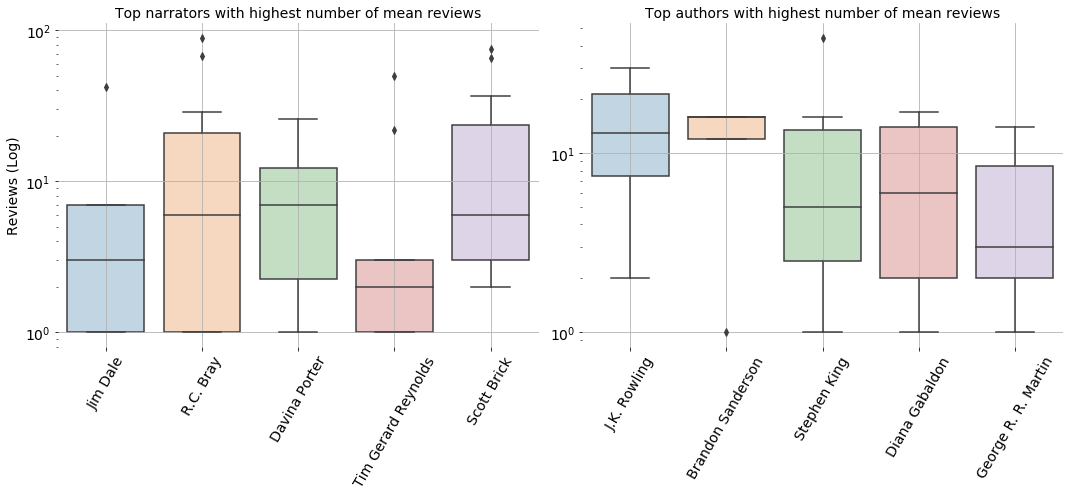

In [268]:
NN=df.groupby(['Narrator Names']).sum().reset_index().sort_values(by='Reviewers',ascending=False)
mydictN = dict(zip(NN['Narrator Names'], NN['Reviewers']))
Nar=df.groupby(['Narrator Names','Category']).count().sort_values(by='Ratings',ascending=False).reset_index()
Nar['Reviewers_M']=Nar['Narrator Names'].apply(lambda x: mydictN[x])
Top_5=Nar.sort_values(by='Reviewers_M',ascending=False)
Review_l=Top_5['Narrator Names'].unique()[:5]

AN=df.groupby(['Author Names']).sum().reset_index().sort_values(by='Reviewers',ascending=False)
mydictA = dict(zip(AN['Author Names'], AN['Reviewers']))
Aut=df.groupby(['Author Names','Category']).count().reset_index()
Aut['Reviewers_M']=Aut['Author Names'].apply(lambda x: mydictA[x])
TopA_5=Aut.sort_values(by='Reviewers_M',ascending=False)
#TopA_5.drop(TopA_5[TopA_5['Author Names']=='Pimsleur'].index,inplace=True)
#TopA_5.drop(TopA_5[TopA_5['Author Names']=='None'].index,inplace=True)
Review_s=TopA_5['Author Names'].unique()[:5]



sns.set_color_codes("muted");

f, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 7));
revplot = sns.boxplot(x='Narrator Names', y='Reviewers', 
                    data=Top_5[(Top_5['Narrator Names'].isin(Review_l))],ax=ax1,order=Review_l);
ax1.set(ylabel="Reviews (Log)",xlabel='',title='Top 5 narrators with highest number of reviews')
ax1.set_xticklabels(revplot.get_xticklabels(), rotation=60, fontsize=14)
ax1.set(yscale="log")
mute_colors(ax1)
ax1.set_ylabel(ylabel="Reviews (Log)",fontsize=14)
revplot2 = sns.boxplot(x='Author Names', y='Reviewers', 
                    data=TopA_5[(TopA_5['Author Names'].isin(Review_s))],ax=ax2);
ax2.set(ylabel="",xlabel='',title='Top 5 authors with highest number of reviews')
ax2.set_xticklabels(revplot2.get_xticklabels(), rotation=60, fontsize=14)
ax2.set(yscale="log")
mute_colors(ax2)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_title('Top authors with highest number of mean reviews', fontdict={'fontsize': 14, 'fontweight': 'medium'})
ax1.set_title('Top narrators with highest number of mean reviews', fontdict={'fontsize': 14, 'fontweight': 'medium'})

ax1.grid(True);ax2.grid(True)
plt.tight_layout();
sns.despine(left=True, bottom=True);

## What are the categories among top narrators and top authors?

In [414]:
N5=Top_5['Narrator Names'].unique()[:5]
Total_df=pd.DataFrame()

for i in N5:
    df_new=df[df['Narrator Names']==i].groupby(['Category']).count().reset_index().sort_values(by='Sub Category',ascending=False)
    df_new['Narrator']=df_new['Category'].apply(lambda x:i)
    Total_df=Total_df.append(df_new)
    
#ct = pd.crosstab(df['Category'], df['Ratings']).reset_index().sort_values(by=4,ascending=False)
Total_df_gr=Total_df.groupby(['Category']).sum().sort_values(by='Sub Category',ascending=False).reset_index()
Total_df_gr.shape

(18, 12)

[Text(0, 0.5, ''), Text(0.5, 0, 'Total Number of Books')]

Text(0.5, 0, 'Total Number of Books (Audible)')

Text(0.5, 1.0, 'Top categories among top 5 narrators')

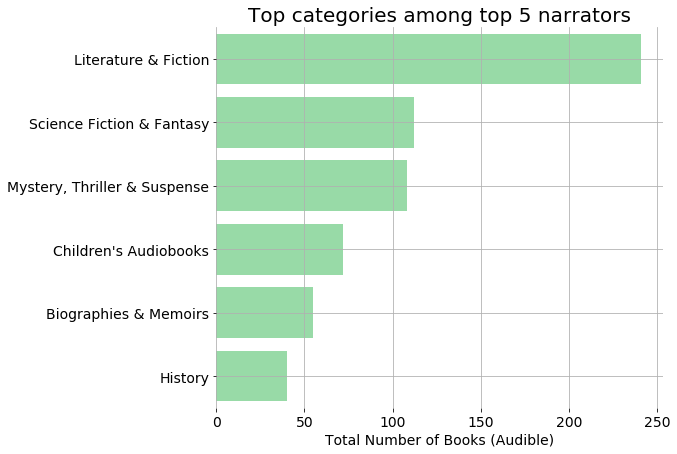

In [374]:
f, ax1 = plt.subplots(1,1,figsize=(8, 7));
sns.set_color_codes("pastel");
sns.barplot(x="Sub Category", y="Category", data=Total_df_gr[:6],ax=ax1,
           linewidth=1.5,color='g');
ax1.set(ylabel="",xlabel="Total Number of Books");
ax1.grid(True);
sns.despine(left=True, bottom=True);
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel(xlabel="Total Number of Books (Audible)",fontsize=14)
ax1.set_title('Top categories among top 5 narrators',fontsize=20)


In [377]:
N5=TopA_5['Author Names'].unique()[:5]
Total_df=pd.DataFrame()
N5
for i in N5:
    df_new=df[df['Author Names']==i].groupby(['Category']).count().reset_index().sort_values(by='Sub Category',ascending=False)
    df_new['Author']=df_new['Category'].apply(lambda x:i)
    Total_df=Total_df.append(df_new)
Total_df_gr=Total_df.groupby(['Category']).sum().sort_values(by='Sub Category',ascending=False).reset_index()
Total_df_gr.shape

array(['J.K. Rowling', 'Brandon Sanderson', 'Stephen King',
       'Diana Gabaldon', 'George R. R. Martin'], dtype=object)

(9, 12)

[Text(0, 0.5, ''), Text(0.5, 0, 'Total Number of Books')]

Text(0.5, 0, 'Total Number of Books (Audible)')

Text(0.5, 1.0, 'Top categories among top 5 authors')

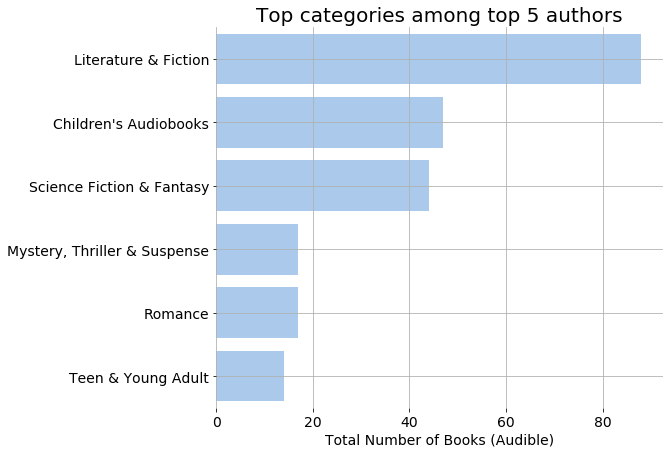

In [376]:
f, ax1 = plt.subplots(1,1,figsize=(8, 7));
sns.set_color_codes("pastel");
sns.barplot(x="Sub Category", y="Category", data=Total_df_gr[:6],ax=ax1,
           linewidth=1.5,color='b');
ax1.set(ylabel="",xlabel="Total Number of Books");
ax1.grid(True);
#plt.tight_layout();
sns.despine(left=True, bottom=True);

ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel(xlabel="Total Number of Books (Audible)",fontsize=14)
ax1.set_title('Top categories among top 5 authors',fontsize=20)
